In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from kalman_filter import KalmanFilter


## Recursive Least Squares Estimation

In [ ]:

# Simulation parameters
true_x = 1.5
C = 10
R = 0.5
N = 100
noise = np.random.normal(0, np.sqrt(R), size=N)
measurements = C * true_x + noise

# RLS estimation
kf_rls = KalmanFilter(A=np.array([[0]]), B=np.array([[0]]), C=np.array([[C]]), R=np.array([[R]]))
estimates = kf_rls.recursive_least_square(measurements, x0=0, P0=0.1)

# Plot
plt.figure()
plt.plot(measurements / C, label='Noisy measurements (normalized)')
plt.plot(estimates.flatten(), label='Kalman estimate')
plt.axhline(true_x, color='r', linestyle='--', label='True value')
plt.legend()
plt.xlabel('Time step')
plt.ylabel('Estimated value')
plt.title('Recursive Least Squares Estimation of Constant')
plt.grid(True)
plt.show()


![image.png](../../images/pendulum_dynamics.png)

## Discrete-Time Kalman Filter Simulation

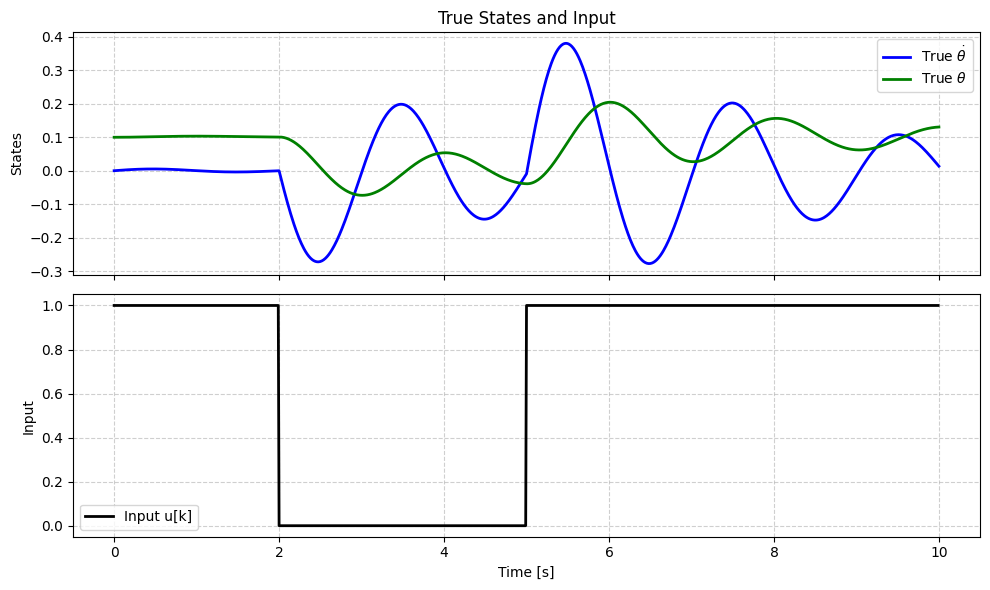

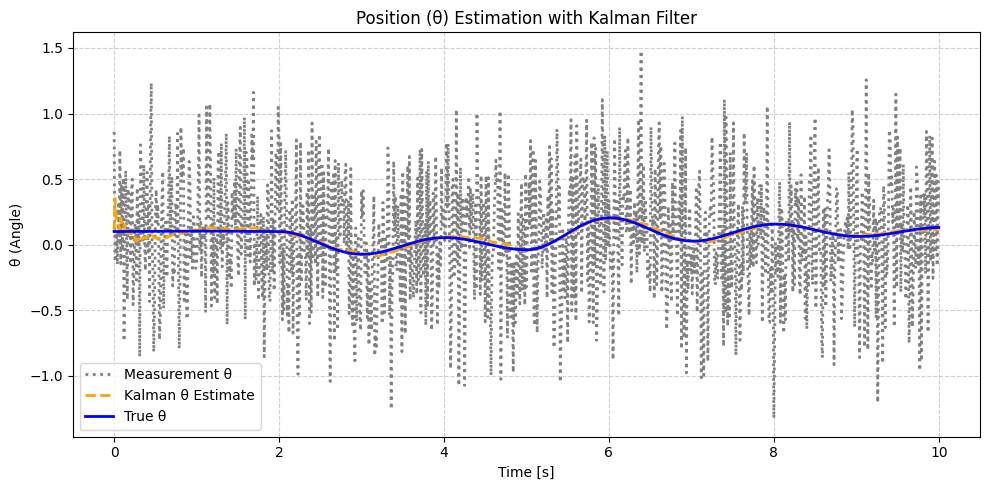

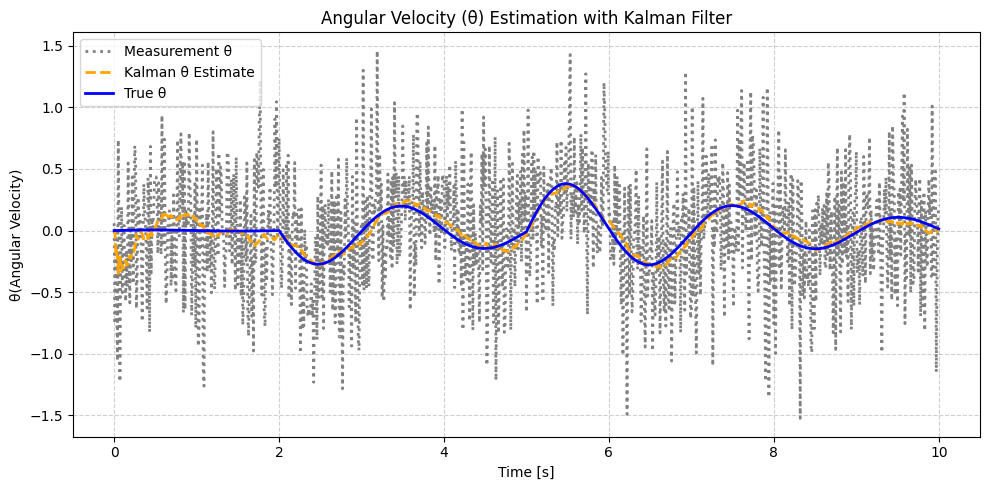

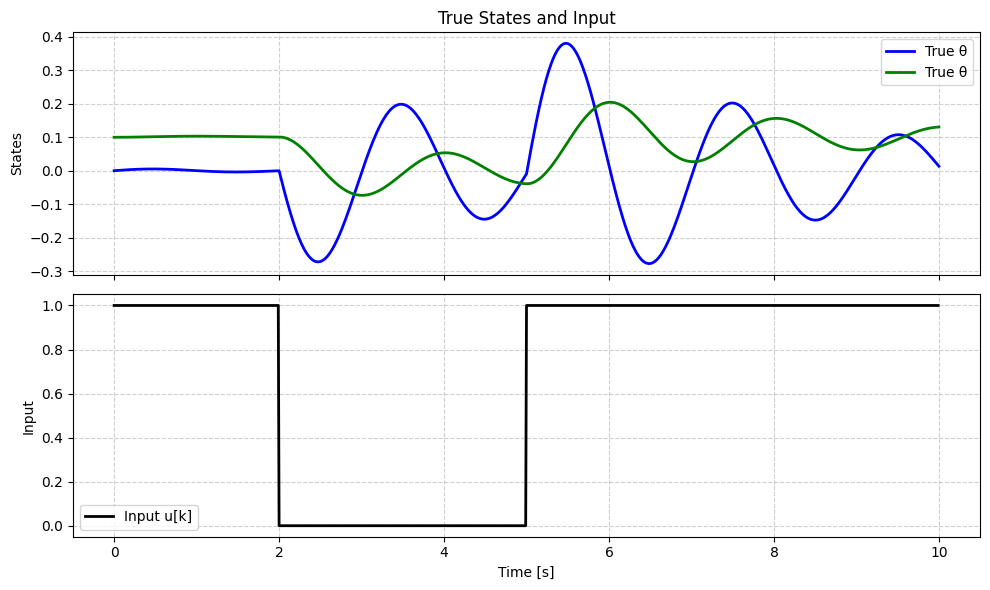

In [ ]:

# Physical parameters
g = 9.81
l = 1.0
m = 1.0
zeta = 0.1
omega_n = np.sqrt(g / l)
A = np.array([[-2 * zeta * omega_n, -omega_n**2], [1, 0]])
B = np.array([[1 / (m * l**2)], [0]])
C = np.eye(2)
L = np.array([[1], [1]])
Q = np.eye(1) * 0.1
R = np.eye(2) * 0.2

# sampling time
T = 0.01

# Create KalmanFilter instance and compute discrete matrices
kf = KalmanFilter(A, B, C, L=L, Q=Q, R=R)
kf.compute_discrete_matrices(T)

# Initial conditions
x0 = np.array([[0.0], [0.1]])   # Initial state: [angular velocity, angle]
P0 = np.eye(2) * 0.1
T_total = 10.0                  # Total simulation time
N_steps = int(T_total / T)

# Control input
u_seq = np.ones((1, N_steps))   # Constant control input
u_seq[0, int(2 / T): int(5 / T)] = 0.0  # Apply zero control input from t=2s to t=5s

# Simulate true system
X_true = np.zeros((2, N_steps + 1)) # plus one for initial state
X_true[:, 0] = x0.flatten()
for k in range(N_steps):
    X_true[:, k + 1] = kf.Phi @ X_true[:, k] + kf.Gamma @ u_seq[:, k]

# Add noise
z = X_true + np.random.multivariate_normal(np.zeros(2), R, N_steps + 1).T
u_seq_noisy = u_seq + np.random.normal(0, np.sqrt(Q[0, 0]), u_seq.shape)

# Kalman filter
X_hat = kf.discrete_time_filter(x0, P0, u_seq_noisy, z)

# Time vector
time = np.linspace(0, T_total, N_steps + 1)

# Plot: True states and Kalman estimates
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Subplot 1: True States (θ and θ̇)
axs[0].plot(time, X_true[0, :], label=r'True $\dot{\theta}$', color='blue', linewidth=2)
axs[0].plot(time, X_true[1, :], label=r'True $\theta$', color='green', linewidth=2)
axs[0].set_ylabel('States')
axs[0].set_title('True States and Input')
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].legend()

# Subplot 2: Input signal
axs[1].plot(time[:-1], u_seq[0, :], label='Input u[k]', color='black', linewidth=2)
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Input')
axs[1].grid(True, linestyle='--', alpha=0.6)
axs[1].legend()

plt.tight_layout()
plt.show()

# Plot: Theta (position)
plt.figure(figsize=(10, 5))
plt.plot(time, z[1, :], linestyle=':', color='gray', linewidth=2, label='Measurement θ')
plt.plot(time, X_hat[1, :], linestyle='--', color='orange', linewidth=2, label='Kalman θ Estimate')
plt.plot(time, X_true[1, :], linestyle='-', color='blue', linewidth=2, label='True θ')
plt.xlabel('Time [s]')
plt.ylabel('θ (Angle)')
plt.title('Position (θ) Estimation with Kalman Filter')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Plot: Angular Velocity (theta_dot)
plt.figure(figsize=(10, 5))
plt.plot(time, z[0, :], linestyle=':', color='gray', linewidth=2, label=r'Measurement $\dot{\theta}$')
plt.plot(time, X_hat[0, :], linestyle='--', color='orange', linewidth=2, label=r'Kalman $\dot{\theta}$ Estimate')
plt.plot(time, X_true[0, :], linestyle='-', color='blue', linewidth=2, label=r'True $\dot{\theta}$')
plt.xlabel('Time [s]')
plt.ylabel('θ̇(Angular Velocity)')
plt.title('Angular Velocity (θ̇) Estimation with Kalman Filter')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
